# binary classification example - titanic dataset

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import copy
import numpy as np
import pandas as pd
import databricks.koalas as ks
from pandas.testing import assert_frame_equal
from pandas.testing import assert_series_equal
from xgboost import XGBClassifier
import treelite
import treelite_runtime
import dill
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from hyperopt import hp
from hyperopt import tpe

In [4]:
from pyspark import SparkConf, SparkContext
conf = SparkConf()
conf.set('spark.executor.memory', '2g')
SparkContext(conf=conf)
ks.set_option('compute.default_index_type', 'distributed-sequence')

21/09/30 10:42:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [5]:
from gators.util import util
# data cleaning
from gators.data_cleaning import (
    DropHighNaNRatio,
    DropLowCardinality,
    DropHighCardinality,
    DropDatatypeColumns,
    DropColumns,
    KeepColumns,
    Replace,
)
# imputers
from gators.imputers import (
    FloatImputer, 
    IntImputer, 
    ObjectImputer,
)
# encoders
from gators.encoders import (
    OrdinalEncoder, 
    WOEEncoder,
    OneHotEncoder
)
# binning
from gators.binning import BinRareEvents
# feature generation
from gators.feature_generation import (
    ClusterStatistics,
    PolynomialFeatures,
)
from gators.feature_generation_str import (
    StringContains,
    StringLength,
    Extract,
    SplitExtract,
)
# feature selection
from gators.feature_selection import (
    SelectFromModel,
    InformationValue
)
#frame converter
from gators.converter import KoalasToPandas
# model building
from gators.model_building import (
    TrainTestSplit,
    HyperOpt,
    XGBBoosterBuilder,
    XGBTreeliteDumper,
)
# pipeline
from gators.pipeline import Pipeline

## offline pipeline - feature selection

### with pandas

In [6]:
data = pd.read_parquet('data/titanic.parquet')
data = data.reset_index(drop=True)
y = data['Survived']
X = data.drop('Survived', axis=1)
train_test_split = TrainTestSplit(test_ratio=0.3, strategy='ordered')
X_train, X_test, y_train, y_test = train_test_split.transform(X, y)

In [7]:
X_train.head(2)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


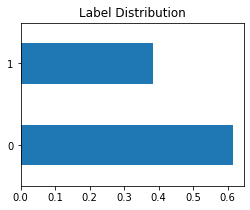

In [8]:
label_counts = data['Survived'].value_counts(normalize=True).sort_values().iloc[::-1]
label_counts.plot(
    kind='barh', 
    figsize=(4, 3), 
    title='Label Distribution',
);

### offline pipeline - data preprocessing & feature selection

In [9]:
k = 14
model = XGBClassifier(
    random_state=0, 
    eval_metric='logloss', 
)
offline_steps = [
    StringLength(['Ticket', 'Cabin', 'Name']),
    SplitExtract(['Name'], [', '], [1], ['Dummy']),
    SplitExtract(['Dummy'], ['.'], [0], ['Title']),
    DropColumns(['Ticket', 'Cabin', 'Name', 'Dummy']),
    ObjectImputer(strategy='constant', value='MISSING'),
    Replace(
        to_replace_dict=
        {'Title': {'Ms': 'Miss', 'Mme': 'Mrs', 'Mlle': 'Miss'}}
    ),
    BinRareEvents(min_ratio=0.1),
    WOEEncoder(),
    FloatImputer(strategy='mean'),
    IntImputer(strategy='constant', value=-1),  
    ClusterStatistics(
        clusters_dict={'FamilyStat': ['SibSp', 'Parch']},
        column_names=['FamilySize', 'FamilyStd'],
    ),
    PolynomialFeatures(
        columns=['Pclass', 'FamilySize', 'Fare', 'Age'],
        degree=2, interaction_only=True),
    DropColumns(columns=['SibSp', 'Parch']),
    SelectFromModel(model=model, k=k)
]
offline_pipe = Pipeline(steps=offline_steps)
X_train_prepro = offline_pipe.fit_transform(X_train, y_train)
X_train_prepro_np = offline_pipe.transform_numpy(X_train.to_numpy())
features = list(X_train_prepro.columns)

In [10]:
assert np.allclose(
    X_train_prepro.to_numpy(),
    X_train_prepro_np
)

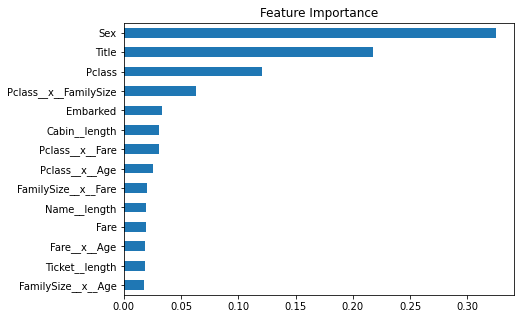

In [11]:
offline_pipe.get_feature_importances(k=k)[::-1].plot(
    kind='barh', 
    figsize=(7, 5), 
    title='Feature Importance',
);

### koalas

In [12]:
data_ks = ks.read_parquet('data/titanic.parquet', index_col='PassengerId')
y_ks = data_ks['Survived']
X_ks = data_ks.drop('Survived', axis=1)

train_test_split = TrainTestSplit(test_ratio=0.3, strategy='ordered')
X_train_ks, X_test_ks, y_train_ks, y_test_ks = \
    train_test_split.transform(X_ks, y_ks)

offline_pipe_ks = Pipeline(steps=offline_steps)
X_train_prepro_ks = offline_pipe_ks.fit_transform(
    X_train_ks, y_train_ks)
X_train_prepro_ks_np = offline_pipe_ks.transform_numpy(
    X_train_ks.to_numpy())

#### check pandas and koalas results match - offline pipeline

In [13]:
assert_frame_equal(
    X_train_prepro, 
    X_train_prepro_ks.to_pandas()
)
assert np.allclose(
    X_train_prepro_np,
    X_train_prepro_ks_np
)

## production pipeline

In [14]:
prod_columns = offline_pipe.get_production_columns()

In [15]:
prod_steps = [
    StringLength(['Ticket', 'Cabin', 'Name']),
    SplitExtract(['Name'], [', '], [1], ['Dummy']),
    SplitExtract(['Dummy'], ['.'], [0], ['Title']),
    DropColumns(['Ticket', 'Cabin', 'Name', 'Dummy']),
    ObjectImputer(strategy='constant', value='MISSING'),
    Replace(
        to_replace_dict=
        {'Title': {'Ms': 'Miss', 'Mme': 'Mrs', 'Mlle': 'Miss'}}
    ),
    BinRareEvents(min_ratio=0.1),
    WOEEncoder(),
    FloatImputer(strategy='mean'),
    IntImputer(strategy='constant', value=-1),  
    ClusterStatistics(
        clusters_dict={'FamilyStat': ['SibSp', 'Parch']},
        column_names=['FamilySize', 'FamilyStd'],
    ),
    PolynomialFeatures(
        columns=['Pclass', 'FamilySize', 'Fare', 'Age'],
        degree=2, interaction_only=True),
    KeepColumns(columns_to_keep=features),
]

### pandas

In [16]:
X_train_prod = X_train[prod_columns]
X_train_prod_np = X_train_prod.to_numpy()

prod_pipe = Pipeline(steps=prod_steps)
_ = prod_pipe.fit(X_train_prod, y_train)
X_train_prod_prepro = prod_pipe.transform(X_train_prod)
X_train_prod_prepro_np = prod_pipe.transform_numpy(
    X_train_prod.to_numpy())

### koalas

In [17]:
X_train_prod_ks = X_train_ks[prod_columns]
X_train_prod_ks_np = X_train_prod.to_numpy()

prod_pipe = Pipeline(steps=prod_steps)
_ = prod_pipe.fit(X_train_prod_ks, y_train_ks)
X_train_prod_prepro_ks = prod_pipe.transform(X_train_prod_ks)
X_train_prod_prepro_ks_np = prod_pipe.transform_numpy(
    X_train_prod_ks.to_numpy())

#### check offline pipeline and production pipeline match

In [18]:
assert_frame_equal(
    X_train_prepro, 
    X_train_prod_prepro
)
assert np.allclose(
    X_train_prod_prepro_np,
    X_train_prepro_np)

#### check pandas and koalas results match - production pipeline

In [19]:
assert np.allclose(
    X_train_prod_prepro_np,
    X_train_prod_prepro_ks_np)
assert_frame_equal(
    X_train_prod_prepro, 
    X_train_prod_prepro_ks.to_pandas()
)
assert np.allclose(
    X_train_prod_prepro_np,
    X_train_prod_prepro_ks_np)


## model building

### numpy

In [20]:
def f1_score(y_true, y_pred):
    p = y_true[y_pred == 1].mean()
    r = y_pred[y_true == 1].mean()
    if (p == 0) | (r == 0):
        return 0
    return 2 * p * r / (p + r)
f1_scoring = make_scorer(f1_score)

y_train_np = y_train.to_numpy()
n_splits = 10
max_evals = 10
kfold = StratifiedKFold(n_splits=n_splits)
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 200, 25),
    'max_depth': hp.quniform('max_depth', 2, 3, 1),
    'learning_rate': hp.loguniform('learning_rate', -4, -1),
    'subsample': hp.uniform('subsample', 0.8, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.8, 1),
 }
model = XGBClassifier(
    random_state=0, 
    use_label_encoder=False,
)
hyper = HyperOpt(
    model=model,
    algo=tpe.suggest,
    scoring=f1_scoring,
    space=space,
    max_evals=max_evals, 
    kfold=kfold,
    features=features,
    )
_ = hyper.fit(X_train_prod_prepro_np, y_train.to_numpy())

100%|████████| 10/10 [00:06<00:00,  1.50trial/s, best loss: -0.7656580416676784]


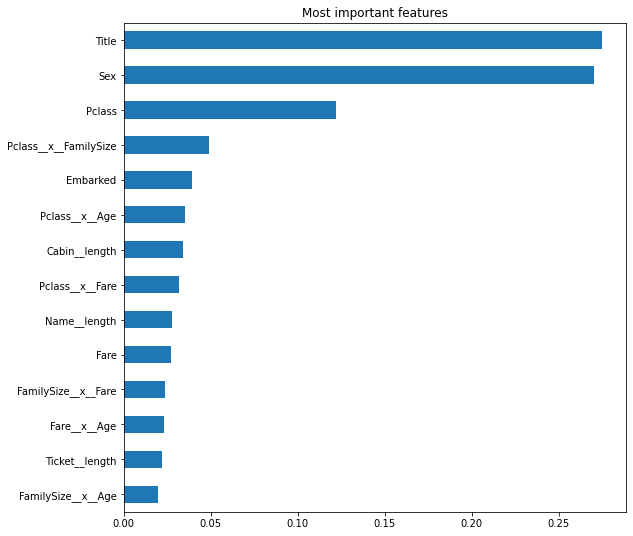

In [21]:
hyper.get_feature_importances().iloc[::-1].plot(
    kind='barh', 
    figsize=(9, 9), 
    title='Most important features',
);

In [22]:
hyper.history.sort_values('loss')

,colsample_bytree,learning_rate,max_depth,n_estimators,subsample,loss,status,id
0,0.916682,0.032935,3.0,175.0,0.897209,-0.765658,ok,0
6,0.866684,0.078750,3.0,200.0,0.967633,-0.765465,ok,6
4,0.963583,0.071731,2.0,175.0,0.829484,-0.763867,ok,4
5,0.836219,0.043136,3.0,125.0,0.846503,-0.760991,ok,5
1,0.971749,0.127459,3.0,175.0,0.906193,-0.759423,ok,1
3,0.848093,0.032530,2.0,100.0,0.905738,-0.757477,ok,3
2,0.852505,0.110585,3.0,200.0,0.851674,-0.754226,ok,2
8,0.810545,0.019879,3.0,150.0,0.902098,-0.753219,ok,8
7,0.847709,0.031836,2.0,175.0,0.993426,-0.751270,ok,7
9,0.889720,0.301286,3.0,200.0,0.818411,-0.738556,ok,9


In [23]:
model_np = copy.copy(hyper.model)
model_path = 'models/model_titanic.dill'
with open(model_path, 'wb') as file:
    dill.dump(model_np, file)

### pandas

In [24]:
model_pd = copy.copy(model_np)
_ = model_pd.fit(X_train_prod_prepro, y_train)

### treelite

In [25]:
xgb_booster = XGBBoosterBuilder.train(
    model=hyper.model, 
    X_train=X_train_prod_prepro_np, 
    y_train=y_train_np,
)

treelite_model = treelite.Model.from_xgboost(xgb_booster)
treelite_model.export_lib(
    toolchain='gcc', 
    libpath='./models/treelite_xgb_titanic.so', 
    params={'parallel_comp': 4},
    verbose=True
)
model_tl = treelite_runtime.Predictor(
    './models/treelite_xgb_titanic.so', verbose=False)

[10:43:47] ../src/compiler/ast_native.cc:45: Using ASTNativeCompiler
[10:43:47] ../src/compiler/ast/split.cc:31: Parallel compilation enabled; member trees will be divided into 4 translation units.
[10:43:47] ../src/c_api/c_api.cc:121: Code generation finished. Writing code to files...
[10:43:47] ../src/c_api/c_api.cc:126: Writing file recipe.json...
[10:43:47] ../src/c_api/c_api.cc:126: Writing file tu3.c...
[10:43:47] ../src/c_api/c_api.cc:126: Writing file tu2.c...
[10:43:47] ../src/c_api/c_api.cc:126: Writing file tu1.c...
[10:43:47] ../src/c_api/c_api.cc:126: Writing file tu0.c...
[10:43:47] ../src/c_api/c_api.cc:126: Writing file header.h...
[10:43:47] ../src/c_api/c_api.cc:126: Writing file main.c...
[10:43:47] /Users/cpoli/gators38/lib/python3.8/site-packages/treelite/contrib/util.py:105: Compiling sources files in directory ./models/tmpeq1fdkam into object files (*.o)...
[10:43:47] /Users/cpoli/gators38/lib/python3.8/site-packages/treelite/contrib/util.py:134: Generating dynam

#### check the models prediction match

In [26]:
X_test_prod = X_test[prod_columns]
X_test_prod_np = X_test_prod.to_numpy()
y_pred_pd = model_pd.predict_proba(
    prod_pipe.transform(X_test_prod))[:, 1]
y_pred_np = model.predict_proba(
    prod_pipe.transform_numpy(X_test_prod_np.copy()))[:, 1]
y_pred_tl = model_tl.predict(
    treelite_runtime.DMatrix(
        prod_pipe.transform_numpy(
            X_test_prod_np.copy()
        )
    )
)
assert np.allclose(y_pred_np, y_pred_pd)
assert np.allclose(y_pred_np, y_pred_tl)

## model evaluation

In [27]:
model_np = copy.copy(hyper.model)
X_test_prod = X_test[prod_columns]
X_test_prod_np = X_test_prod.to_numpy()
X_test_prod_prepro_np = prod_pipe.transform(X_test_prod).to_numpy()
y_test_pred = model_np.predict(X_test_prod_prepro_np)
f'f1 score: {f1_score(y_test, y_test_pred):.2f}'

'f1 score: 0.76'

## per-sample bechmarking

### pipeline only

In [28]:
x = X_test_prod.iloc[[0]]
x_np = x.to_numpy()
stats_pd = %timeit -o prod_pipe.transform(x)
stats_np = %timeit -o prod_pipe.transform_numpy(x_np.copy())

37 ms ± 3.28 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
132 µs ± 5.52 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [29]:
speedup = 1e3 * float(str(stats_pd).split(' ')[0]) / float(str(stats_np).split(' ')[0])
f'Speed-up Pandas VS Numpy x{round(speedup)}'

'Speed-up Pandas VS Numpy x280'

### pipeline & model

In [30]:
stats_pd = %timeit -o model_pd.predict(prod_pipe.transform(x))[0]
stats_np = %timeit -o model.predict(prod_pipe.transform_numpy(x_np.copy()))[0]
stats_tl = %timeit -o  model_tl.predict(treelite_runtime.DMatrix(prod_pipe.transform_numpy(x_np.copy())))

36.1 ms ± 5.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
322 µs ± 24.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
203 µs ± 10.8 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [31]:
speedup = 1e3 * float(str(stats_pd).split(' ')[0]) / float(str(stats_np).split(' ')[0])
f'Speed-up Pandas VS Numpy x{round(speedup)}'

'Speed-up Pandas VS Numpy x112'

In [32]:
speedup = 1e3 * float(str(stats_pd).split(' ')[0]) / float(str(stats_tl).split(' ')[0])
f'Speed-up Pandas VS Numpy&Treelite x{round(speedup)}'

'Speed-up Pandas VS Numpy&Treelite x178'